In [23]:
import sys
import time
import pandas as pd
import numpy as np
import re
import random
from pprint import pprint
from itertools import combinations
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform
from clustering.sbd import sbd
import matplotlib.pyplot as plt
from citest.fisher_z import ci_test_fisher_z
from statsmodels.tsa.stattools import adfuller

## Parameters ###################################################
DATA_FILE = "../data/20200821_user-db_cpu-load_01.json"
TARGET_DATA = {"containers": "all",
               "services": "all",
               "nodes": "all",
               "middlewares": "all"}
PLOTS_NUM = 240
SIGNIFICANCE_LEVEL = 0.05
THRESHOLD_DIST = 0.001
#################################################################

# Prepare data matrix
raw_data = pd.read_json(DATA_FILE)
data_df = pd.DataFrame()
for target in TARGET_DATA:
    for t in raw_data[target].dropna():
        for metric in t:
            if metric["metric_name"] in TARGET_DATA[target] or TARGET_DATA[target] == "all":
                metric_name = metric["metric_name"].replace("container_", "").replace("node_", "")
                target_name = metric["{}_name".format(target[:-1]) if target != "middlewares" else "container_name"].replace("gke-microservices-experi-default-pool-", "")
                if re.match("^gke-microservices-experi", target_name):
                    continue
                column_name = "{}-{}_{}".format(target[0], target_name, metric_name)
                data_df[column_name] = np.array(metric["values"], dtype=np.float)[:, 1][:PLOTS_NUM]
data_df = data_df.round(4)

# Prepare target list
containers_list = []
services_list = []
nodes_list = []
for col in data_df.columns:
    if re.match("^c-", col):
        container_name = col.split("_")[0].replace("c-", "")
        if container_name not in containers_list:
            containers_list.append(container_name)
    elif re.match("^s-", col):
        service_name = col.split("_")[0].replace("s-", "")
        if service_name not in services_list:
            services_list.append(service_name)
    elif re.match("^n-", col):
        node_name = col.split("_")[0].replace("n-", "")
        if node_name not in nodes_list:
            nodes_list.append(node_name)
            
# Aggregate the dimension of a metric
metrics_dimension = {}
for target in TARGET_DATA:
    metrics_dimension[target] = {}

def count_metrics(metrics_dimension, dataframe, n):
    for col in dataframe.columns:
        if re.match("^c-", col):
            container_name = col.split("_")[0].replace("c-", "")   
            if container_name not in metrics_dimension["containers"]:
                metrics_dimension["containers"][container_name] = [0,0,0]        
            metrics_dimension["containers"][container_name][n] += 1
        elif re.match("^m-", col):
            middleware_name = col.split("_")[0].replace("m-", "")    
            if middleware_name not in metrics_dimension["middlewares"]:
                metrics_dimension["middlewares"][middleware_name] = [0,0,0]
            metrics_dimension["middlewares"][middleware_name][n] += 1
        elif re.match("^s-", col):
            service_name = col.split("_")[0].replace("s-", "")
            if service_name not in metrics_dimension["services"]:
                metrics_dimension["services"][service_name] = [0,0,0]
            metrics_dimension["services"][service_name][n] += 1
        elif re.match("^n-", col):
            node_name = col.split("_")[0].replace("n-", "")
            if node_name not in metrics_dimension["nodes"]:
                metrics_dimension["nodes"][node_name] = [0,0,0]
            metrics_dimension["nodes"][node_name][n] += 1
    return metrics_dimension

metrics_dimension = count_metrics(metrics_dimension, data_df, 0)
metrics_dimension["total"] = [len(data_df.columns)]
pprint(metrics_dimension)

{'containers': {'carts': [55, 0, 0],
                'carts-db': [51, 0, 0],
                'catalogue': [53, 0, 0],
                'catalogue-db': [51, 0, 0],
                'front-end': [53, 0, 0],
                'orders': [55, 0, 0],
                'orders-db': [51, 0, 0],
                'payment': [55, 0, 0],
                'queue-master': [55, 0, 0],
                'rabbitmq': [51, 0, 0],
                'session-db': [49, 0, 0],
                'shipping': [55, 0, 0],
                'user': [55, 0, 0],
                'user-db': [51, 0, 0]},
 'middlewares': {'carts-db': [124, 0, 0],
                 'orders-db': [124, 0, 0],
                 'user-db': [127, 0, 0]},
 'nodes': {'66a015a7-eq47': [264, 0, 0],
           '66a015a7-g7qj': [264, 0, 0],
           '66a015a7-i5rl': [264, 0, 0],
           '66a015a7-w0i8': [264, 0, 0]},
 'services': {'carts': [2, 0, 0],
              'catalogue': [2, 0, 0],
              'front-end': [2, 0, 0],
              'orders': [2, 0, 0],


In [24]:
# Reduce metrics
## Step 1: Reduced metrics with stationarity
reduced_by_st_df = pd.DataFrame()
for col in data_df.columns:
    data = data_df[col].values
    if data.sum() == 0. or np.isnan(data.sum()):
        p_val = np.nan
    else:
        p_val = adfuller(data)[1]
    if not np.isnan(p_val):
        if p_val >= SIGNIFICANCE_LEVEL:
            reduced_by_st_df[col] = data_df[col]

metrics_dimension = count_metrics(metrics_dimension, reduced_by_st_df, 1)
metrics_dimension["total"].append(len(reduced_by_st_df.columns))
pprint(metrics_dimension)

/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/.venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/hi-tsuruta/go/src/github.com/yuuki/microservices-demo/causal-discovery/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


{'containers': {'carts': [55, 5, 0],
                'carts-db': [51, 7, 0],
                'catalogue': [53, 4, 0],
                'catalogue-db': [51, 1, 0],
                'front-end': [53, 1, 0],
                'orders': [55, 2, 0],
                'orders-db': [51, 7, 0],
                'payment': [55, 5, 0],
                'queue-master': [55, 1, 0],
                'rabbitmq': [51, 4, 0],
                'session-db': [49, 1, 0],
                'shipping': [55, 7, 0],
                'user': [55, 4, 0],
                'user-db': [51, 9, 0]},
 'middlewares': {'carts-db': [124, 19, 0],
                 'orders-db': [124, 16, 0],
                 'user-db': [127, 10, 0]},
 'nodes': {'66a015a7-eq47': [264, 40, 0],
           '66a015a7-g7qj': [264, 36, 0],
           '66a015a7-i5rl': [264, 41, 0],
           '66a015a7-w0i8': [264, 51, 0]},
 'services': {'carts': [2, 1, 0],
              'catalogue': [2, 0, 0],
              'front-end': [2, 1, 0],
              'orders': [2, 

In [25]:
## Step 2: Reduced by hierarchical clustering
def hierarchical_clustering(target_df, clustering_info):
    series = target_df.values.T
    dist = pdist(series, metric=sbd)
    dist_matrix = squareform(dist)
    z = linkage(dist, method="single", metric=sbd)
    labels = fcluster(z, t=THRESHOLD_DIST, criterion="distance")
    cluster_dict = {}
    for i, v in enumerate(labels):
        if v not in cluster_dict:
            cluster_dict[v] = [i]
        else:
            cluster_dict[v].append(i)
    remove_list = []
    for c in cluster_dict:
        cluster_metrics = cluster_dict[c]
        if len(cluster_metrics) == 2:
            # Select the representative metric at random
            shuffle_list = random.sample(cluster_metrics, len(cluster_metrics))
            clustering_info[target_df.columns[shuffle_list[0]]] = [target_df.columns[shuffle_list[1]]]
            remove_list.append(target_df.columns[shuffle_list[1]])
        elif len(cluster_metrics) > 2:
            # Select medoid as the representative metric
            distances = []
            for met1 in cluster_metrics:
                dist_sum = 0
                for met2 in cluster_metrics:
                    if met1 != met2:
                        dist_sum += dist_matrix[met1][met2]
                distances.append(dist_sum)
            medoid = cluster_metrics[np.argmin(distances)]
            clustering_info[target_df.columns[medoid]] = []
            for r in cluster_metrics:
                if r != medoid:
                    remove_list.append(target_df.columns[r])
                    clustering_info[target_df.columns[medoid]].append(target_df.columns[r])                 
    return clustering_info, remove_list

# Clustering metrics of containers and middlewares
clustering_info = {}
reduced_df = reduced_by_st_df
for con in containers_list:
    con_df = reduced_by_st_df.loc[:, reduced_by_st_df.columns.str.startswith(("c-{}_".format(con), "m-{}_".format(con)))]
    if len(con_df.columns) in [0, 1]:
        continue
    clustering_info, remove_list = hierarchical_clustering(con_df, clustering_info)
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)

# Clustering metrics of nodes
for node in nodes_list:
    node_df = reduced_by_st_df.loc[:, reduced_by_st_df.columns.str.startswith("n-{}_".format(node))]
    if len(node_df.columns) in [0, 1]:
        continue
    clustering_info, remove_list = hierarchical_clustering(node_df, clustering_info)
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)
        
# Clustering metrics of services
for ser in services_list:
    service_df = reduced_by_st_df.loc[:, reduced_by_st_df.columns.str.startswith("s-{}_".format(ser))]
    if len(service_df.columns) in [0, 1]:
        continue
    clustering_info, remove_list = hierarchical_clustering(service_df, clustering_info)
    for r in remove_list:
        reduced_df = reduced_df.drop(r, axis=1)

metrics_dimension = count_metrics(metrics_dimension, reduced_df, 2)
metrics_dimension["total"].append(len(reduced_df.columns))
pprint(metrics_dimension)

{'containers': {'carts': [55, 5, 2],
                'carts-db': [51, 7, 3],
                'catalogue': [53, 4, 2],
                'catalogue-db': [51, 1, 1],
                'front-end': [53, 1, 1],
                'orders': [55, 2, 2],
                'orders-db': [51, 7, 3],
                'payment': [55, 5, 1],
                'queue-master': [55, 1, 1],
                'rabbitmq': [51, 4, 1],
                'session-db': [49, 1, 1],
                'shipping': [55, 7, 3],
                'user': [55, 4, 1],
                'user-db': [51, 9, 6]},
 'middlewares': {'carts-db': [124, 19, 6],
                 'orders-db': [124, 16, 3],
                 'user-db': [127, 10, 3]},
 'nodes': {'66a015a7-eq47': [264, 40, 8],
           '66a015a7-g7qj': [264, 36, 5],
           '66a015a7-i5rl': [264, 41, 8],
           '66a015a7-w0i8': [264, 51, 13]},
 'services': {'carts': [2, 1, 1],
              'catalogue': [2, 0, 0],
              'front-end': [2, 1, 1],
              'orders': [2,

In [26]:
clustering_info

{'c-carts_memory_usage_bytes': ['c-carts_last_seen',
  'c-carts_memory_rss',
  'c-carts_memory_working_set_bytes'],
 'c-catalogue_memory_working_set_bytes': ['c-catalogue_last_seen',
  'c-catalogue_memory_usage_bytes'],
 'c-payment_memory_usage_bytes': ['c-payment_fs_usage_bytes',
  'c-payment_last_seen',
  'c-payment_memory_rss',
  'c-payment_memory_working_set_bytes'],
 'c-shipping_last_seen': ['c-shipping_fs_usage_bytes',
  'c-shipping_memory_rss',
  'c-shipping_memory_working_set_bytes',
  'c-shipping_memory_usage_bytes'],
 'c-user_memory_working_set_bytes': ['c-user_last_seen',
  'c-user_memory_rss',
  'c-user_memory_usage_bytes'],
 'c-orders-db_memory_working_set_bytes': ['c-orders-db_memory_max_usage_bytes',
  'c-orders-db_fs_usage_bytes',
  'c-orders-db_last_seen',
  'c-orders-db_memory_rss',
  'm-orders-db_process_resident_memory_bytes',
  'm-orders-db_mongodb_mongod_op_latencies_latency_total',
  'm-orders-db_go_memstats_other_sys_bytes',
  'm-orders-db_mongodb_tcmalloc_gener

# 可視化

In [27]:
# 正規化
normalized_df = pd.DataFrame()
for column in data_df.columns:
    data = data_df[column].values
    mean = data.mean()
    if mean == 0. :
        continue    
    normalized_df[column] = data_df[column] / data.mean()

<AxesSubplot:>

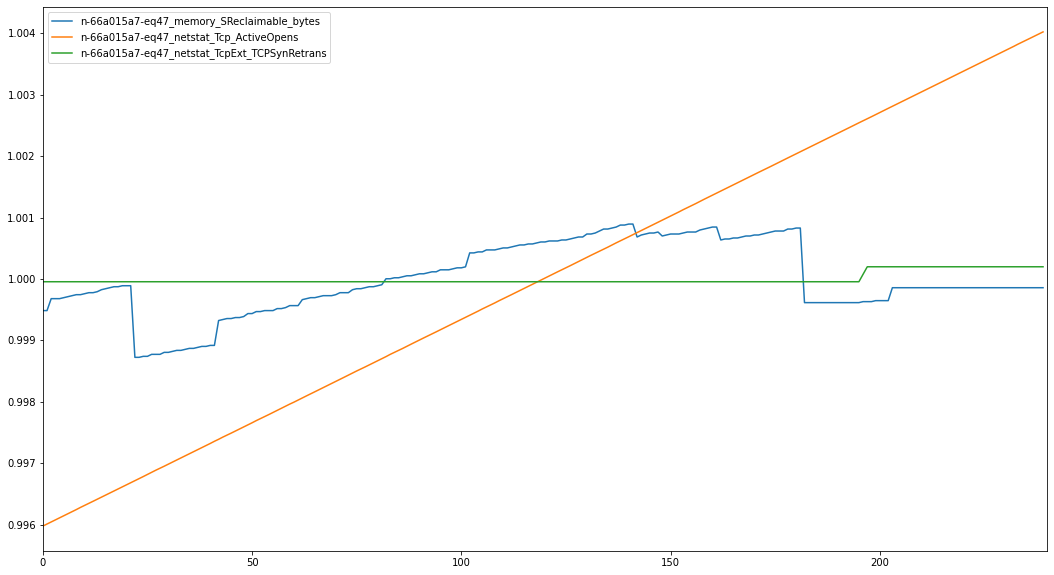

In [28]:
df = pd.DataFrame()
mets = ["n-66a015a7-eq47_memory_SReclaimable_bytes", "n-66a015a7-eq47_netstat_Tcp_ActiveOpens", "n-66a015a7-eq47_netstat_TcpExt_TCPSynRetrans"]
for m in mets:
    df[m] = normalized_df[m]
df.plot(figsize=(18, 10), xlim=[0,240])